In [1]:
import re
import numpy as np
import pandas as pd
from rdkit import Chem
from tqdm.auto import tqdm
from pandarallel import pandarallel

from nncomp_molecule import constants

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
train_df = pd.read_csv(constants.COMPETITION_DATADIR / "train_labels.csv")
submission_df = pd.read_csv(constants.COMPETITION_DATADIR / "sample_submission.csv")

display(train_df.head())
display(submission_df.head())

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


,image_id,InChI
0,00000d2a601c,InChI=1S/H2O/h1H2
1,00001f7fc849,InChI=1S/H2O/h1H2
2,000037687605,InChI=1S/H2O/h1H2
3,00004b6d55b6,InChI=1S/H2O/h1H2
4,00004df0fe53,InChI=1S/H2O/h1H2


<AxesSubplot:>

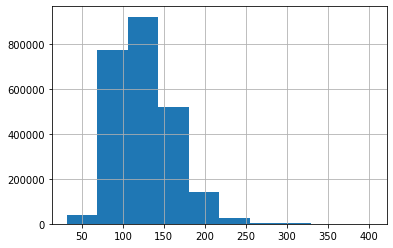

In [3]:
train_df.InChI.apply(len).hist()

In [4]:
def parse_inchi(inchi):
    inchi_layers = inchi.split("/")
    inchi_h = ""
    inchi_sublayers = []
    if len(inchi_layers) > 3:
        if inchi_layers[3].startswith("h"):
            inchi_h = inchi_layers[3]
        else:
            inchi_sublayers.append(inchi_layers[3])
    if len(inchi_layers) > 4:
        inchi_sublayers.extend(inchi_layers[4:])
    return {
        "InChI_atoms": inchi_layers[1],
        "InChI_c": inchi_layers[2],
        "InChI_h": inchi_h,
        "InChI_sub": "/".join(inchi_sublayers),
    }


parse_inchi(train_df.InChI[3476])

{'InChI_atoms': 'C15H14N2O',
 'InChI_c': 'c1-17-14(11-7-3-2-4-8-11)16-13-10-6-5-9-12(13)15(17)18',
 'InChI_h': 'h2-10,14,16H,1H3',
 'InChI_sub': 'i/hD'}

In [5]:
inchi_layers_df = train_df.InChI.parallel_apply(parse_inchi)
inchi_layers_df = pd.DataFrame(inchi_layers_df.tolist())
train_df = train_df.assign(**inchi_layers_df)

In [6]:
def decode_inchi(row):
    inchi = "InChI=1S/" + row.InChI_atoms
    inchi += "/" + row.InChI_c
    if row.InChI_h != "":
        inchi += "/" + row.InChI_h
    if row.InChI_sub != "":
        inchi += "/" + row.InChI_sub
    return inchi


train_df["decoded_InChI"] = train_df.progress_apply(decode_inchi, axis=1)
train_df["is_reproduced"] = (train_df.decoded_InChI == train_df.InChI)
len(train_df.query("~is_reproduced"))

0

In [7]:
train_df["InChI_h_len"] = train_df.InChI_h.apply(len)
train_df["InChI_c_len"] = train_df.InChI_c.apply(len)
train_df["InChI_sub_len"] = train_df.InChI_sub.apply(len)
train_df.InChI_h_len.max(), train_df.InChI_c_len.max(), train_df.InChI_sub_len.max()

(139, 267, 92)

In [32]:
from collections import Counter

counter = Counter()
train_df.mol.progress_apply(
    lambda mol:
    counter.update([atom.GetSymbol() for atom in mol.GetAtoms()])
)
counter

Counter({'C': 43578389,
         'O': 5999833,
         'S': 930321,
         'N': 6388664,
         'Br': 213052,
         'F': 934721,
         'Cl': 537676,
         'P': 19716,
         'Si': 22882,
         'B': 7182,
         'I': 29476,
         'H': 6766})

In [33]:
train_df.InChI[0]

'InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3'